In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd.variable import Variable
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import imageio

In [ ]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,),(0.5,))
                ])
to_image = transforms.ToPILImage()
trainset = MNIST(root='./data/', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)

device = 'cuda'

100%|██████████| 9912422/9912422 [00:00<00:00, 113900441.20it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 22701591.80it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32578025.96it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3118947.08it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 128
        self.n_out = 784
        self.fc0 = nn.Sequential(
                    nn.Linear(self.n_features, 256),
                    nn.LeakyReLU(0.2)
                    )
        self.fc1 = nn.Sequential(
                    nn.Linear(256, 512),
                    nn.LeakyReLU(0.2)
                    )
        self.fc2 = nn.Sequential(
                    nn.Linear(512, 1024),
                    nn.LeakyReLU(0.2)
                    )
        self.fc3 = nn.Sequential(
                    nn.Linear(1024, self.n_out),
                    nn.Tanh()
                    )
    def forward(self, x):
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = x.view(-1, 1, 28, 28)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_in = 784
        self.n_out = 1
        self.fc0 = nn.Sequential(
                    nn.Linear(self.n_in, 1024),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc1 = nn.Sequential(
                    nn.Linear(1024, 512),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc2 = nn.Sequential(
                    nn.Linear(512, 256),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc3 = nn.Sequential(
                    nn.Linear(256, self.n_out),
                    nn.Sigmoid()
                    )
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)

g_optim = optim.Adam(generator.parameters(), lr=2e-4)
d_optim = optim.Adam(discriminator.parameters(), lr=2e-4)

g_losses = []
d_losses = []
images = []

criterion = nn.BCELoss()

def noise(n, n_features=128):
    return Variable(torch.randn(n, n_features)).to(device)

def make_ones(size):
    data = Variable(torch.ones(size, 1))
    return data.to(device)

def make_zeros(size):
    data = Variable(torch.zeros(size, 1))
    return data.to(device)

In [ ]:
def train_discriminator(optimizer, real_data, fake_data):
    n = real_data.size(0)
    optimizer.zero_grad()
    prediction_real = discriminator(real_data)
    error_real = criterion(prediction_real, make_ones(n))
    error_real.backward()
    prediction_fake = discriminator(fake_data)
    error_fake = criterion(prediction_fake, make_zeros(n))
    error_fake.backward()
    optimizer.step()
    return error_real + error_fake

def train_generator(optimizer, fake_data):
    n = fake_data.size(0)
    optimizer.zero_grad()
    prediction = discriminator(fake_data)
    error = criterion(prediction, make_ones(n))
    error.backward()
    optimizer.step()
    return error

In [ ]:
num_epochs = 250
k = 1
test_noise = noise(64)

generator.train()
discriminator.train()
for epoch in range(num_epochs):
    g_error = 0.0
    d_error = 0.0
    for i, data in enumerate(trainloader):
        imgs, _ = data
        n = len(imgs)
        # for j in range(k):
        fake_data = generator(noise(n)).detach()
        real_data = imgs.to(device)
        d_error += train_discriminator(d_optim, real_data, fake_data)
        fake_data = generator(noise(n))
        g_error += train_generator(g_optim, fake_data)

    img = generator(test_noise).cpu().detach()
    img = make_grid(img)
    images.append(img)
    g_losses.append(g_error/i)
    d_losses.append(d_error/i)
    print('Epoch {}: g_loss: {:.8f} d_loss: {:.8f}\r'.format(epoch, g_error/i, d_error/i))

print('Training Finished')
torch.save(generator.state_dict(), 'mnist_generator.pth')

Epoch 0: g_loss: 4.35872412 d_loss: 0.60697854
Epoch 1: g_loss: 4.53275967 d_loss: 0.62950152
Epoch 2: g_loss: 2.21013236 d_loss: 0.92196292
Epoch 3: g_loss: 2.36324787 d_loss: 0.76810730
Epoch 4: g_loss: 3.43707204 d_loss: 0.40562046
Epoch 5: g_loss: 2.91832829 d_loss: 0.53412223
Epoch 6: g_loss: 3.11625028 d_loss: 0.50914168
Epoch 7: g_loss: 2.60406709 d_loss: 0.59477192
Epoch 8: g_loss: 2.51561427 d_loss: 0.60160285
Epoch 9: g_loss: 2.47128701 d_loss: 0.63531160
Epoch 10: g_loss: 2.34859872 d_loss: 0.66075116
Epoch 11: g_loss: 2.27696228 d_loss: 0.66731983
Epoch 12: g_loss: 2.11645937 d_loss: 0.72138333
Epoch 13: g_loss: 2.15728760 d_loss: 0.74384272
Epoch 14: g_loss: 1.93465972 d_loss: 0.81598693
Epoch 15: g_loss: 1.96517062 d_loss: 0.76423889
Epoch 16: g_loss: 1.83123171 d_loss: 0.83684778
Epoch 17: g_loss: 1.68868399 d_loss: 0.88111162
Epoch 18: g_loss: 1.72506034 d_loss: 0.86151832
Epoch 19: g_loss: 1.78770828 d_loss: 0.83337182
Epoch 20: g_loss: 1.65506303 d_loss: 0.90358186
Ep

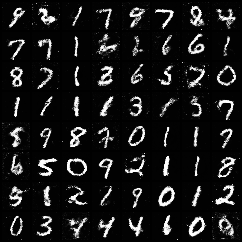

In [ ]:
display(to_image(images[249]))

In [ ]:
import torch
from torchvision import utils
import os

idx=1
for image in images:
    # Convert the tensor to a PIL image
    image=to_image(image)
    # pil_image = utils.tensor_to_image(image)
    # Save the PIL image with the index as part of the file name
    file_name = f"image_{idx}.png"
    file_path = os.path.join("/content/vanillaGan_images_epochs", file_name)
    image.save(file_path)
    idx+=1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
idx=1
for image in images:
  image=to_image(image)
  file_name = f"image_{idx}.png"
  file_path = os.path.join("/content/drive/My Drive/vanilla_images_epochs", file_name)
  image.save(file_path)
  idx+=1
# from PIL import Image
# import numpy as np

# # Example image array (replace this with your image data)
# image_array = np.random.randint(0, 255, size=(200, 200, 3), dtype=np.uint8)

# Convert the numpy array to a PIL image
# image_pil = Image.fromarray(image_array)

# Save the image to Google Drive (replace '/content/drive/My Drive/' with your desired directory path)
# image_pil.save('/content/drive/My Drive/image.png')

# Save the image to the local Colab environment
# image_pil.save('image.png')


In [ ]:
imgs = [np.array(to_image(i)) for i in images]
imageio.mimsave('vanilla_progress.gif', imgs)

In [ ]:
# Assuming 'to_image' is a function that converts a tensor to an image
# Replace 'images' with your list of tensors
imgs = [np.array(to_image(i.cpu())) for i in images]  # Use .cpu() to move tensor to CPU
imageio.mimsave('progress.gif', imgs)

generator_losses=[tensor.item() for tensor in g_losses]
discriminator_losses=[tensor.item() for tensor in d_losses]
plt.plot(generator_losses, label='Generator_Losses')
plt.plot(discriminator_losses, label='Discriminator Losses')
plt.legend()
plt.savefig('loss.png')

In [ ]:
print(d_losses[0].item())

In [ ]:
data = [torch.tensor(0.8919, device='cuda:0', requires_grad=True),
        torch.tensor(0.7764, device='cuda:0', requires_grad=True),
        torch.tensor(0.5432, device='cuda:0', requires_grad=True)]

# Extract numerical values from each tensor


In [ ]:
print(values)